![head.png](https://github.com/cafawo/FinancialDataAnalytics/blob/master/figures/head.jpg?raw=1)

# Financial Data Analytics in Python

**Prof. Dr. Fabian Woebbeking**</br>
Assistant Professor of Financial Economics

IWH - Leibniz Institute for Economic Research</br>
MLU - Martin Luther University Halle-Wittenberg

fabian.woebbeking@iwh-halle.de

# Homework: Linear Regression and Optimization

You will need a Git/GitHub repository to submit your course deliverables. Consult [**slides.ipynb**](https://github.com/iwh-halle/FinancialDataAnalytics) for help with the tasks below! If you need further assistance, do not hesitate to open a Q&A at https://github.com/iwh-halle/FinancialDataAnalytics/discussions

In this assignment you will work with data that is stored in a file named **02_python_data.csv**, which contains daily stock prices for various companies listed on Deutsche Börse (Xetra). The columns are labeled with Reuters identifier code (RIC). The first RIC '.GDAXI' is the german DAX index, the remaining RICs represent its constituents.

In this exercise we will compare the **DAX index** (.GDAXI) to a portfolio build from the **constituents** (the remaining columns).

### Task:

Find the vector of weights $\mathbf{w}$ for the [Minimum Variance Portfolio (MVP)](https://en.wikipedia.org/wiki/Modern_portfolio_theory) using only the constituents (not .GDAXI). Print risk ($\sigma$) and return ($\mu$) of both, DAX and MVP. Show in a single graph the cumulative log-returns of both portfolios. Please note that the sum of $\mathbf{w}$ must be $100$%. ALso, you are not allowed to use short positions, i.e. $w \ge 0\ \forall\ w \in \mathbf{w}$.

Hint: The portfolio variance - which we want to minimize - is given by
$$
\sigma^2_\text{Portfolio} = \mathbf{w}^\intercal \mathbf{\Sigma} \mathbf{w},
$$
where $\mathbf{\Sigma}$ is the correlation matrix of the portfolio constituents.

Replicating Portfolio Mean Return: 0.0005
Replicating Portfolio Risk: 0.0128
DAX Mean Return: 0.0006
DAX Risk: 0.0121


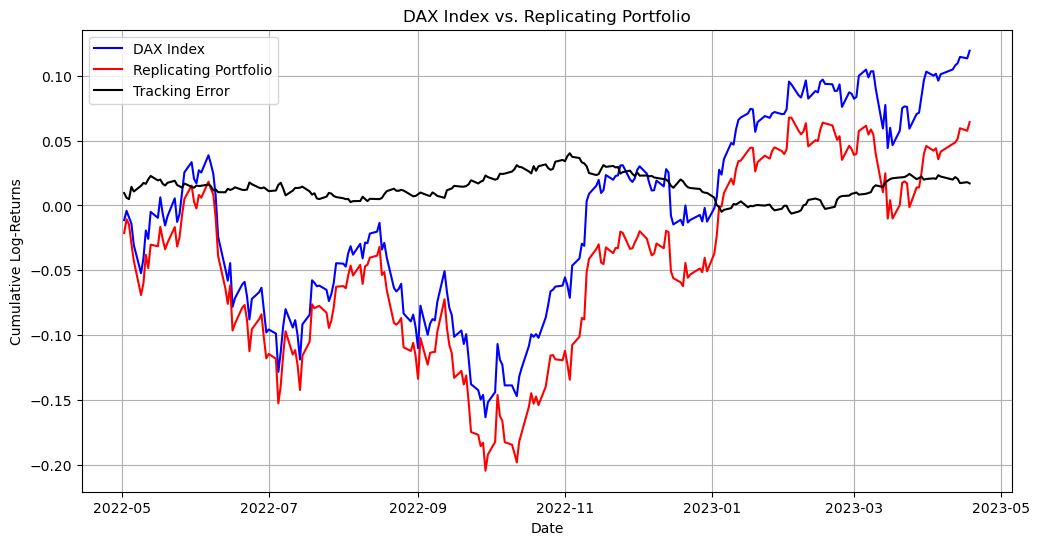

In [46]:
####https://lumos-datascience.medium.com/mean-variance-portfolio-optimization-using-python-8485fccb9f8b
###Did not work due to issues with the PyPortfolioOpt Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Load data from CSV file
data = pd.read_csv('02_python_data.csv', index_col=0, parse_dates=True)

# Extract DAX data
dax_prices = data.iloc[:, 0]
dax_returns = dax_prices.pct_change().dropna()

# Extract portfolio data and calculate returns
portfolio_prices = data.iloc[:, 1:]
portfolio_returns = portfolio_prices.pct_change().dropna()

# Calculate the covariance matrix of the portfolio constituents
cov_matrix = portfolio_returns.cov()

# Number of assets in the portfolio
num_assets = len(portfolio_returns.columns)

# Define the function to minimize (portfolio variance)
def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

# Constraints: weights sum to 1
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

# Bounds: no short positions, weights between 0 and 1
bounds = tuple((0, 1) for asset in range(num_assets))

# Initial guess for weights
initial_weights = num_assets * [1. / num_assets]

# Optimize the portfolio weights to minimize the variance
opt_result = minimize(portfolio_variance, initial_weights, args=(cov_matrix,), method='SLSQP', bounds=bounds, constraints=constraints)

# Optimal weights
optimal_weights = opt_result.x

# Calculate returns of the replicating portfolio
rep_portfolio_returns = np.dot(portfolio_returns, optimal_weights)
rep_portfolio_risk = np.std(rep_portfolio_returns)
rep_portfolio_mean_return = np.mean(rep_portfolio_returns)
rep_portfolio_cum_returns = np.cumsum(rep_portfolio_returns)

# Print replicating portfolio statistics
print(f"Replicating Portfolio Mean Return: {rep_portfolio_mean_return:,.4f}")
print(f"Replicating Portfolio Risk: {rep_portfolio_risk:,.4f}")

# Calculate DAX statistics
dax_cum_returns = dax_returns.cumsum()
dax_risk = np.std(dax_returns)
dax_mean_return = np.mean(dax_returns)

# Print DAX statistics
print(f"DAX Mean Return: {dax_mean_return:,.4f}")
print(f"DAX Risk: {dax_risk:,.4f}")

# Calculate log-returns
log_returns = np.log(data) - np.log(data.shift(1))
log_returns = log_returns.dropna()

# Calculate log-returns for the replicating portfolio
log_returns_portfolio = pd.DataFrame(np.dot(log_returns.iloc[:, 1:], optimal_weights), index=log_returns.index)
log_returns_dax = pd.DataFrame(log_returns.iloc[:, :1])

# Plotting
plt.figure(figsize=(12, 6))

# Plot log-returns of DAX index and replicating portfolio
plt.plot(log_returns_dax.cumsum(), label='DAX Index', color='blue')
plt.plot(log_returns_portfolio.cumsum(), label='Replicating Portfolio', color='red')

# Calculate and plot tracking error
tracking_err = dax_cum_returns - rep_portfolio_cum_returns
plt.plot(tracking_err.index, tracking_err, label='Tracking Error', color='black')

# Add titles and labels
plt.title('DAX Index vs. Replicating Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Log-Returns')

# Show legend and grid
plt.legend()
plt.grid(True)
plt.show()

### Task:

Use a linear regression model to find the actual weights of the index constituents that are required to replicate (i.e. explain) the returns of the DAX index. Print risk and return and show in a single graph the cumulative log-returns of both portfolios. Also show the [tracking error](https://en.wikipedia.org/wiki/Tracking_error) as the difference between the index and the replicating portfolio in the same figure.

Replicating Portfolio Mean Return: 0.0006
Replicating Portfolio Risk: 0.0120
DAX Mean Return: 0.0006
DAX Risk: 0.0121


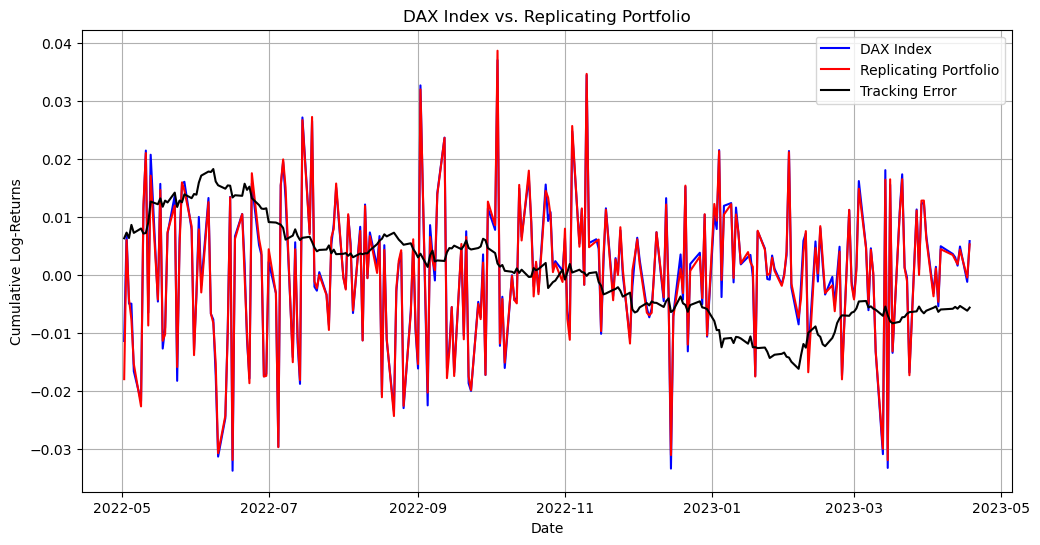

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Load data from CSV file
data = pd.read_csv('02_python_data.csv', index_col=0, parse_dates=True)

# Extract DAX data
dax_prices = data.iloc[:, 0]
dax_returns = dax_prices.pct_change().dropna()

# Extract portfolio data and calculate returns
portfolio_prices = data.iloc[:, 1:]
portfolio_returns = portfolio_prices.pct_change().dropna()

# Fit linear regression model to find the weights
lin_model = LinearRegression()
lin_model.fit(portfolio_returns, dax_returns)
portfolio_weights = lin_model.coef_

# Calculate returns of the replicating portfolio
rep_portfolio_returns = np.dot(portfolio_returns, portfolio_weights)
rep_portfolio_risk = np.std(rep_portfolio_returns)
rep_portfolio_mean_return = np.mean(rep_portfolio_returns)
rep_portfolio_cum_returns = rep_portfolio_returns.cumsum()

# Print replicating portfolio statistics
print(f"Replicating Portfolio Mean Return: {rep_portfolio_mean_return:,.4f}")
print(f"Replicating Portfolio Risk: {rep_portfolio_risk:,.4f}")

# Calculate DAX statistics
dax_cum_returns = dax_returns.cumsum()
dax_risk = np.std(dax_returns)
dax_mean_return = np.mean(dax_returns)

# Print DAX statistics
print(f"DAX Mean Return: {dax_mean_return:,.4f}")
print(f"DAX Risk: {dax_risk:,.4f}")

# Calculate log-returns
log_returns = np.log(data) - np.log(data.shift(1))
log_returns = log_returns.dropna()

# Calculate log-returns for the replicating portfolio
log_returns_portfolio = pd.DataFrame(np.dot(log_returns.iloc[:, 1:], portfolio_weights), index=log_returns.index)
log_returns_dax = pd.DataFrame(log_returns.iloc[:, :1])

# Plotting
plt.figure(figsize=(12, 6))

# Plot log-returns of DAX index and replicating portfolio
plt.plot(log_returns_dax, label='DAX Index', color='blue')
plt.plot(log_returns_portfolio, label='Replicating Portfolio', color='red')

# Calculate and plot tracking error
tracking_err = dax_cum_returns - rep_portfolio_cum_returns
plt.plot(tracking_err.index, tracking_err, label='Tracking Error', color='black')

# Add titles and labels
plt.title('DAX Index vs. Replicating Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Log-Returns')

# Show legend and grid
plt.legend()
plt.grid(True)
plt.show()

### Task:

We want to create a ["smart-beta"](https://en.wikipedia.org/wiki/Smart_beta) strategy that replicates the DAX index returns using only a subset of its constituents. This is, maximize the fit of the model using only $3$ constituents. This process is similar to [feature selection](https://en.wikipedia.org/wiki/Feature_selection) in machine learning. Print risk and return and show in a single graph the cumulative log-returns of both portfolios. Also show the [tracking error](https://en.wikipedia.org/wiki/Tracking_error) as the difference between the index and the replicating portfolio in the same figure.

Optimal Combination: ('SIEGn.DE', 'ALVG.DE', 'IFXGn.DE')
Replicating Portfolio Mean Return: 0.0006
Replicating Portfolio Risk: 0.0113
DAX Mean Return: 0.0006
DAX Risk: 0.0121


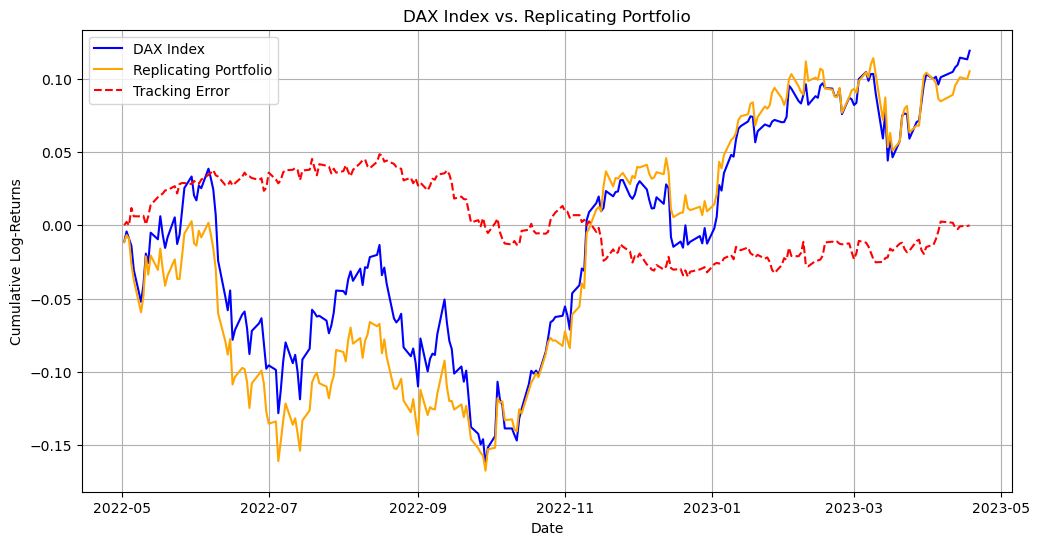

In [45]:
###Method by highest Model fit via R Squared in linear regression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from itertools import combinations

# Load data from CSV file
data = pd.read_csv('02_python_data.csv', index_col=0, parse_dates=True)

# Extract DAX data
dax_prices = data.iloc[:, 0]
dax_returns = dax_prices.pct_change().dropna()

# Extract portfolio data and calculate returns
portfolio_prices = data.iloc[:, 1:]
portfolio_returns = portfolio_prices.pct_change().dropna()

# Function to fit linear regression and calculate R-squared
def fit_linear_model(portfolio_subset, dax_ret):
    reg_model = LinearRegression()
    reg_model.fit(portfolio_subset, dax_ret)
    r2_score = reg_model.score(portfolio_subset, dax_ret)
    return reg_model, r2_score

# Iterate through all combinations of 3 constituents
max_r2_score = -np.inf
optimal_model = None
optimal_combination = None

for combo in combinations(portfolio_returns.columns, 3):
    portfolio_subset = portfolio_returns[list(combo)]
    model, r2_score = fit_linear_model(portfolio_subset, dax_returns)
    if r2_score > max_r2_score:
        max_r2_score = r2_score
        optimal_model = model
        optimal_combination = combo

# Calculate returns of the best replicating portfolio
optimal_portfolio_returns = portfolio_returns[list(optimal_combination)]
rep_portfolio_returns = optimal_model.predict(optimal_portfolio_returns)
rep_portfolio_risk = np.std(rep_portfolio_returns)
rep_portfolio_mean_return = np.mean(rep_portfolio_returns)
rep_portfolio_cum_returns = np.cumsum(rep_portfolio_returns)

# Print replicating portfolio statistics
print(f"Optimal Combination: {optimal_combination}")
print(f"Replicating Portfolio Mean Return: {rep_portfolio_mean_return:,.4f}")
print(f"Replicating Portfolio Risk: {rep_portfolio_risk:,.4f}")

# Calculate DAX statistics
dax_cum_returns = np.cumsum(dax_returns)
dax_risk = np.std(dax_returns)
dax_mean_return = np.mean(dax_returns)

# Print DAX statistics
print(f"DAX Mean Return: {dax_mean_return:,.4f}")
print(f"DAX Risk: {dax_risk:,.4f}")

# Calculate log-returns
log_returns = np.log(data) - np.log(data.shift(1))
log_returns = log_returns.dropna()

# Calculate log-returns for the replicating portfolio using the selected 3 constituents
log_returns_portfolio_subset = log_returns[list(optimal_combination)]
log_returns_portfolio = pd.DataFrame(np.dot(log_returns_portfolio_subset, optimal_model.coef_), index=log_returns.index)
log_returns_dax = pd.DataFrame(log_returns.iloc[:, 0])

# Plotting
plt.figure(figsize=(12, 6))

# Plot cumulative log-returns of DAX index and replicating portfolio
plt.plot(log_returns_dax.cumsum(), label='DAX Index', color='blue')
plt.plot(log_returns_portfolio.cumsum(), label='Replicating Portfolio', color='orange')

# Calculate tracking error
tracking_err = dax_cum_returns - rep_portfolio_cum_returns

# Plot tracking error
plt.plot(tracking_err.index, tracking_err, label='Tracking Error', color='red', linestyle='--')

# Add titles and labels
plt.title('DAX Index vs. Replicating Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Log-Returns')

# Show legend and grid
plt.legend()
plt.grid(True)
plt.show()
